In [1]:
%load_ext autoreload
%autoreload 2

import einops as ein
import torch
import matplotlib.pyplot as plt

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    PointLights, 
    RasterizationSettings,
    MeshRenderer, 
    MeshRasterizer,  
    HardFlatShader,
)

# add path for demo utils functions 
from PIL import Image
from collections import Counter
import sys
import natsort
import glob
import json
import numpy as np
import os
from matplotlib import cm

sys.path.append(os.path.abspath(''))


In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [3]:
from taskonomy_mesh import load_taskonomy_obj_to_mesh, create_taskonomy_camera, parse_filename, LabelFile, View
from viewpoint_aggregation import aggregate_3d
from shaders import HardVeryFlatShader

In [4]:
DATA_DIR = "./data"
model = 'onaga' # onaga benicia

orig_mem = torch.cuda.max_memory_allocated(0) / 2**20
obj_filename = os.path.join(DATA_DIR, f"{model}/taskonomy.obj")
mesh = load_taskonomy_obj_to_mesh(obj_filename, device=device)

new_mem = torch.cuda.max_memory_allocated(0) / 2**20
print(f"Memory used: {new_mem - orig_mem} MB")

Memory used: 204.07568359375 MB


In [5]:
size = 0.0
for k in mesh._INTERNAL_TENSORS:
    v = getattr(mesh, k)
    if torch.is_tensor(v):
        print(v.nelement())
        size += v.element_size() * v.nelement()
        
verts_list = mesh.verts_list()
faces_list = mesh.faces_list()

for v in verts_list:
    size += v.element_size() * v.nelement()
    
for v in faces_list: 
    size += v.element_size() * v.nelement()


print(size)

1
1
1
41259821.0


# Load a few points

In [6]:
image_size = 256

all_cameras = {}
semseg_labels = {}
rgb = {}
all_views = []
view_per_point = Counter()
for i, point_file in enumerate(natsort.natsorted(glob.glob(f'./data/{model}/point_info/*'))):
    if i < 0: continue
    print(point_file)
    basename = os.path.basename(point_file)
    lf = LabelFile(**parse_filename(point_file))
    lf = View(lf.point, lf.view)
    view_per_point[lf.point] += 1
    all_views.append(lf)

    with open(point_file) as f:
        data = json.load(f)

    all_cameras[lf] = data
    semseg_labels[lf] = torch.tensor(np.array(
            Image.open(f'./data/{model}/segment_semantic/point_{lf.point}_view_{lf.view}_domain_segmentsemantic.png').resize((image_size, image_size))
        ))
    rgb[lf] = torch.tensor(np.array(
            Image.open(f'./data/{model}/rgb/point_{lf.point}_view_{lf.view}_domain_rgb.png').resize((image_size, image_size))
        ))

    if i == 17:
        break

./data/onaga/point_info/point_0_view_0_domain_point_info.json
./data/onaga/point_info/point_0_view_1_domain_point_info.json
./data/onaga/point_info/point_0_view_2_domain_point_info.json
./data/onaga/point_info/point_0_view_3_domain_point_info.json
./data/onaga/point_info/point_1_view_0_domain_point_info.json
./data/onaga/point_info/point_1_view_1_domain_point_info.json
./data/onaga/point_info/point_1_view_2_domain_point_info.json
./data/onaga/point_info/point_1_view_3_domain_point_info.json
./data/onaga/point_info/point_1_view_4_domain_point_info.json
./data/onaga/point_info/point_1_view_5_domain_point_info.json
./data/onaga/point_info/point_2_view_0_domain_point_info.json
./data/onaga/point_info/point_2_view_1_domain_point_info.json
./data/onaga/point_info/point_2_view_2_domain_point_info.json
./data/onaga/point_info/point_2_view_3_domain_point_info.json
./data/onaga/point_info/point_3_view_0_domain_point_info.json
./data/onaga/point_info/point_3_view_1_domain_point_info.json
./data/o

In [7]:
lf = all_views[1]

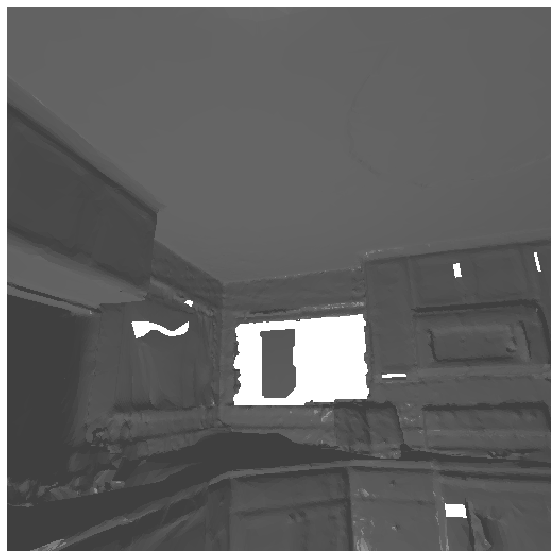

In [8]:
data, im_rgb, im_semseg = all_cameras[lf], rgb[lf], semseg_labels[lf]

cameras = create_taskonomy_camera(data, device)

raster_settings = RasterizationSettings(image_size=512, blur_radius=0.0, faces_per_pixel=1)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=HardVeryFlatShader(cameras=cameras, lights=None, device=device,))


images, fragments = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");
images1 = images

## Visualize semantic segmentation preditions from FCN

In [9]:
# Visualise SS
cmap = cm.get_cmap('Set1')
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:3], [0.299, 0.587, 0.114])

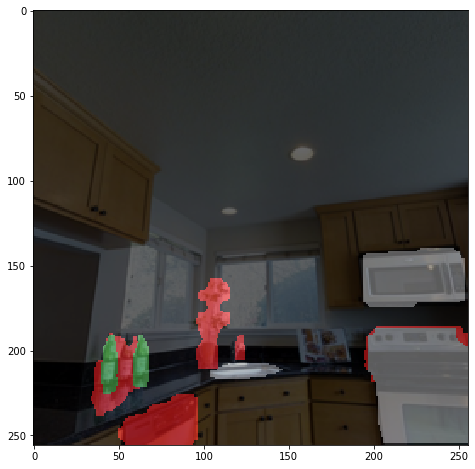

In [10]:
alpha = 0.6
ss = cmap(semseg_labels[lf])[...,:3]
ss[semseg_labels[lf] == 1] = 0.0
im = ss * alpha + np.array(rgb[lf]/255.) * (1 - alpha)
plt.figure(figsize = (8,8))
plt.imshow(im)
plt.show()

In [11]:
def one_hot(targets, C=18):    
    targets_extend=targets.clone().to(targets.device)
    targets_extend.unsqueeze_(1) # convert to Nx1xHxW
    one_hot = torch.FloatTensor(targets_extend.size(0), C, targets_extend.size(2), targets_extend.size(3)).zero_().to(targets.device)
    one_hot.scatter_(1, targets_extend, 1) 
    return one_hot

In [12]:
# Generate annealed predictions
point = '2'
C = 18
eps = 0.5
preds = []
views = []
cameras = []
for view in range(view_per_point[point]):
    v = View(point, str(view))
    views.append(v)
    data, im_rgb, im_semseg = all_cameras[v], rgb[v], semseg_labels[v]
    oh = one_hot(im_semseg.type(torch.LongTensor).to(device).unsqueeze(0), C)
    uncertainty = 0.0
    uncertain_class = torch.ones_like(oh) / C * (1 - uncertainty)
#     uncertain_class[:,0] += uncertainty
    oh = eps * oh + (1 - eps) * uncertain_class
#     oh = oh.flip(dims=(1,))
    oh = torch.log(oh)
    preds.append(ein.rearrange(oh, 'b c h w -> b h w c'))
    cameras.append(create_taskonomy_camera(all_cameras[v], device))

# preds = torch.cat(preds, dim=0)

In [13]:
import einops as ein
from pytorch3d.renderer.cameras import CamerasBase
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer import (
    BlendParams,
    MeshRenderer,
    MeshRasterizer,
    RasterizationSettings,
    hard_rgb_blend
    )
from pytorch3d.structures import Meshes
import torch
from torch import nn
from torch.nn.parallel import parallel_apply

import typing
from typing import List, Tuple, Optional


class ShadelessShader(nn.Module):
    def __init__(self, blend_params=None, device="cpu"):
        super().__init__()
        self.blend_params = blend_params if blend_params is not None else BlendParams()
            
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        texels = meshes.sample_textures(fragments)
        images = hard_rgb_blend(texels, fragments, self.blend_params)
        return images, fragments.pix_to_face # (N, H, W, 3) RGBA image

class ReturnFragmentsShader(nn.Module):
    def __init__(self, blend_params=None, device="cpu"):
        super().__init__()
        self.blend_params = blend_params if blend_params is not None else BlendParams()
            
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        return fragments # (N, H, W, 3) RGBA image
    
def get_fragments(cameras: List[CamerasBase],
                 mesh: Meshes,
                 image_size: int,
                 device: Optional[str]=None):

    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
    # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
    # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
    # the difference between naive and coarse-to-fine rasterization. 
    raster_settings = RasterizationSettings(image_size=image_size,
                                        blur_radius=0.0,
                                        faces_per_pixel=1)
    renderers = [MeshRenderer(
                    rasterizer=MeshRasterizer(
                        cameras=camera, 
                        raster_settings=raster_settings
                    ),
                    shader=ReturnFragmentsShader( device=device, )
                ) for camera in cameras]

    # this could be serial to trade off speed for less memory consumption
    fragments_all = parallel_apply(renderers, [mesh] * len(renderers), devices=[device] * len(renderers))
    return fragments_all


def aggregate_labels(fragments_all, logits_all, scaling=torch.sqrt, use_sparse_optimizations=True):
    '''
        fragments_all
        logits_all
    '''
    # type: (List[Tensor],List[Tensor]) -> Tensor
    # TODO: This will be very memory-inefficient for big meshes with a lot of faces.
    # We can fix this by creating a mapping idx -> face_idx to make this dense again. 
    # TODO: This only works for a single image. Need to make it work for batches. 

    device = fragments_all[0].device
    # only for a single image
    faces_per_image = torch.tensor([int(f.max()) for f in fragments_all])
    logits_shape = int(torch.tensor([l.shape[-1] for l in logits_all]).max())
    n_channels = logits_all[0].shape[-1]

    assert logits_all[0].shape[1] == logits_all[0].shape[2], f"predictions should be shape B x W x H x C, not {logits_all[0].shape}. soft_combine only handles square predictions."

    if use_sparse_optimizations:
        all_faces = torch.cat([fragments.unique() for fragments in fragments_all]).unique()
        face_to_compacted_idx = torch.zeros(int(all_faces.max() + 2), dtype=torch.int64, device=device)
        face_to_compacted_idx[all_faces] = torch.arange(0, len(all_faces)).to(face_to_compacted_idx.device)
        faces_compacted = torch.zeros((len(all_faces), logits_shape), device=device)
    else:
        faces_compacted = torch.zeros((int(faces_per_image.max() + 2), logits_shape), device=device)    
        face_to_compacted_idx = None

    # Aggregate labels from each input prediction
#     for fragments, logits in zip(fragments_all, logits_all):
    def add_count(fragments, logits):
        new_faces_compacted = torch.zeros_like(faces_compacted)
        unique_faces, counts = fragments.detach().unique(return_counts=True)

        # Do voting based on reprojection 
        flat_frags = ein.rearrange(fragments, 'b h w c -> (b c h w)')
        if use_sparse_optimizations:
            flat_frags = face_to_compacted_idx[flat_frags]
        
        flat_logits = ein.rearrange(logits, 'b h w c -> (b c h w)')
    
        flat_frags_repeated = torch.cat(n_channels*[flat_frags])        
        flat_idxs = torch.repeat_interleave(torch.arange(0, n_channels), 
                                            repeats=flat_frags.numel(),
                                            dim=0)

        new_faces_compacted.index_put_((flat_frags_repeated, flat_idxs),
                             flat_logits,
                             accumulate=True)
        
        scaled_counts = scaling(counts.view(-1, 1).float())

        # Normalize and add
        if use_sparse_optimizations:
            faces_compacted[face_to_compacted_idx[unique_faces]] += (new_faces_compacted[face_to_compacted_idx[unique_faces]] / scaled_counts)
            #  faces_compacted += (new_faces_compacted / scaled_counts)  # might be faster if high utilization
        else:
            faces_compacted[unique_faces] += (new_faces_compacted[unique_faces] / scaled_counts)
    
    # this could be serial to trade off speed for less memory consumption
    parallel_apply([add_count] * len(fragments_all),
                   list(zip(fragments_all, logits_all)),
                   devices=[device] * len(fragments_all))

    return faces_compacted, face_to_compacted_idx

def aggregate_3d(cameras: List[CamerasBase],
                 predictions: List[torch.Tensor],
                 mesh: Meshes,
                 image_size: int,
                 device: Optional[str]=None,
                 scaling_fn=None,
                 use_sparse_optimizations=True) -> List[torch.Tensor]:
    '''
        Args:
            cameras: A list of Cameras for which we will render target views of the given mesh. 
            predictions:  A list of B x W x H x C predictions corresponding to the given cameras. 
                These will be used to determine a 'consistent' labeling of the mesh.
            image_size: How big to render out the target predictions. Can be different than input predictions. 
            mesh: A 'Meshes' object.
                TODO: I think that this is supposed to be a batch.
            device: On which device to do the processing. 
            scaling_fn: A function that, if n_pixels in a prediction corresponding to a specific 
                mesh face, scaling_fn(n_pixels) determines the weighting. Specifically:
                >>>  prediction_contribution = sum(predictions_for_face) / scaling(n_pixels)
            use_sparse_optimizations: Turn off for debugging
    
        Returns:
            target_predictions: A list of 'consistent' predictions, rendered according to the 
                viewpoints specified in 'cameras'
    '''
    # Get pix -> face correspondences for each prediction
    fragments = get_fragments(cameras, mesh, image_size, device)
    
    
    # Aggregate labels in 3d
    if scaling_fn is None:
        scaling_fn = lambda x: torch.sqrt(x)
    face_labels, face_to_idx = aggregate_labels([f.pix_to_face for f in fragments],
                               predictions,
                               scaling=scaling_fn,
                               use_sparse_optimizations=use_sparse_optimizations)
    
    # Reproject those labels back onto initial images
    if use_sparse_optimizations:
        target_predictions = [face_labels[face_to_idx[f.pix_to_face.flatten()]].reshape(p.shape) for f, p in zip(fragments, predictions)]
    else: 
        target_predictions = [face_labels[f.pix_to_face.flatten()].reshape(p.shape) for f, p in zip(fragments, predictions)]
    return target_predictions

In [14]:
orig_mem = torch.cuda.max_memory_allocated(0) / 2**20
# print(torch.cuda.memory_summary(0))

In [15]:
%%timeit
# .split(1, dim=0)
target_predictions = aggregate_3d(cameras, preds, mesh, image_size, device, scaling_fn=lambda x: 1, use_sparse_optimizations=False)


250 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(torch.cuda.memory_summary(0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  199620 KB |  545889 KB |   22360 MB |   22165 MB |
|       from large pool |  197551 KB |  536651 KB |   22208 MB |   22015 MB |
|       from small pool |    2069 KB |   11286 KB |     152 MB |     150 MB |
|---------------------------------------------------------------------------|
| Active memory         |  199620 KB |  545889 KB |   22360 MB |   22165 MB |
|       from large pool |  197551 KB |  536651 KB |   22208 MB |

In [17]:
new_mem = torch.cuda.max_memory_allocated(0) / 2**20
print(f"Memory used: {new_mem - orig_mem} MB")

# initial_targets = torch.load('correct.pth') # scaling fn = 1.0
# assert (initial_targets - torch.stack(target_predictions)).abs().max() == 0.0

Memory used: 67.33544921875 MB


In [18]:
import seaborn as sns
import torch
import numpy as np

# Visualise SS
def rgb2gray(rgb):
    return torch.tensor(np.dot(rgb[:,:,:3], [0.299, 0.587, 0.114])) / 255.0

DEFAULT_LABELS = ['uncertain',
 'background',
 'bottle',
 'chair',
 'couch',
 'potted_plant',
 'bed',
 'dining_table',
 'toilet',
 'tv',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase']


def colorize_semseg(pred, cmap=None, uncertain_class=1):
    if cmap is None:
        cmap = cm.get_cmap('tab20')

    p = torch.tensor(pred).max(dim=-1)[1].cpu().numpy()
    ss = cmap(p)[...,:3]
#     ss[p == uncertain_class] = 0.0
    return ss

def show_semseg_legend(target_predictions, labels=DEFAULT_LABELS, cmap='tab20', show=True):
    vals, counts = torch.stack(target_predictions).squeeze().cpu().max(dim=-1)[1].unique(return_counts=True)
    pal = np.array(sns.color_palette(cmap))
    brightness_factor = 8
    pal[vals] *= brightness_factor
    pal /= brightness_factor
    sns.palplot(pal[:len(labels)])
    plt.xticks(range(len(labels)), labels)
    if show:
        plt.show()
    
def plot_consistent_preds(rgb, original_preds, consistent_preds, names=None,
                          alpha=0.6, scale=4, show=True, batch_idx=0):
    
    ''' 
        rgb: a batch of B x W x H x C images
        original_preds: a batch of B x W x H images
        consistent_preds: a batch of B x W x H images
        names: names for each column
        
    '''
    assert 0.0 <= alpha and alpha <= 1.0, 'alpha must be between 0 and 1'
    n_views = len(rgb)
    assert n_views == len(original_preds) and n_views == len(consistent_preds)  
    

    fig, ax = plt.subplots(nrows=2, ncols=n_views, figsize = (scale * n_views, 2 * scale))

    for j, view in enumerate(names):
        for i, row in enumerate(ax):
            p = [original_preds, consistent_preds][i][j]
            im = p * alpha + np.array(rgb[j]) * (1 - alpha)
            row[j].imshow(im)
            if j == 0:
                row[j].set_ylabel(['Original', 'Consistent'][i])
            if i == 0:
                row[j].set_title(names[j])

    plt.tight_layout()
    if show:
        plt.show()

rgbs = [rgb2gray(rgb[v]).unsqueeze(-1) for v in views]        
orig_preds = [colorize_semseg(p).squeeze(0) for p in preds]
consistent_preds = [colorize_semseg(p).squeeze(0) for p in target_predictions]

plot_consistent_preds(rgbs, orig_preds, consistent_preds, views)
show_semseg_legend(target_predictions)

<ipython-input-18-bf617dc713f0>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(pred).max(dim=-1)[1].cpu().numpy()


NameError: name 'target_predictions' is not defined

In [ ]:
torch.stack(target_predictions).squeeze().max(dim=-1)[1].unique(return_counts=True)

In [ ]:
assert False
initial_targets = aggregate_3d(cameras, preds, mesh, 256, device, scaling_fn=lambda x: 1)
torch.save(torch.stack(initial_targets), 'correct.pth')